## Time-Series Decomposition (Chosen approach)

Extract the seasonal patterns from the time-series

In [43]:
from data_exploitation.exports_analytics.data.scripts import time_series_generator
from data_exploitation.exports_analytics.exploratory_data_analysis.scripts import time_granularities_analysis, time_granularities_generator
from database_settings import postgres_utilities
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr
import wandb
from sklearn.metrics import mean_squared_error, mean_absolute_error



### Get available headings

In [44]:
# Get available headings from peru_exports_sandbox
engine = postgres_utilities.engine()
available_headings = postgres_utilities.run_query_file(engine,
                                                       './../data/queries/read_available_headings.sql')
available_headings = pd.DataFrame(available_headings)
available_headings

Connected to Formatted Zone successfully!


,heading,description
0,0712909000,Otras hortalizas y mezclas de hortalizas corta...
1,0805291000,Tangelo (Citrus reticulata x Citrus paradisis)...
2,0810400000,"Arándanos rojos, mirtilos y demas frutos del g..."
3,0713359000,"Frijoles (fréjoles, porotos, alubias, judías) ..."
4,0805502100,"Limón (limón sutil, limón común, limón criollo..."
5,0810901000,"Granadilla, maracuya (parchita) y demas frutas..."
6,0702000000,Tomates frescos o refrigerados
7,0709999000,Otras hortalizas frescas o refrigeradas
8,0801220000,Nueces del Brasil sin cáscara
9,0710400000,"Maiz dulce incluso cocidos, congelados"


### Build a time-series

In [45]:
# Choose a heading
# chosen_heading = '0810400000'
chosen_heading = '0805502100'
# Choose the observed measure (usd_kg or net_weight)
observations = 'usd_kg'

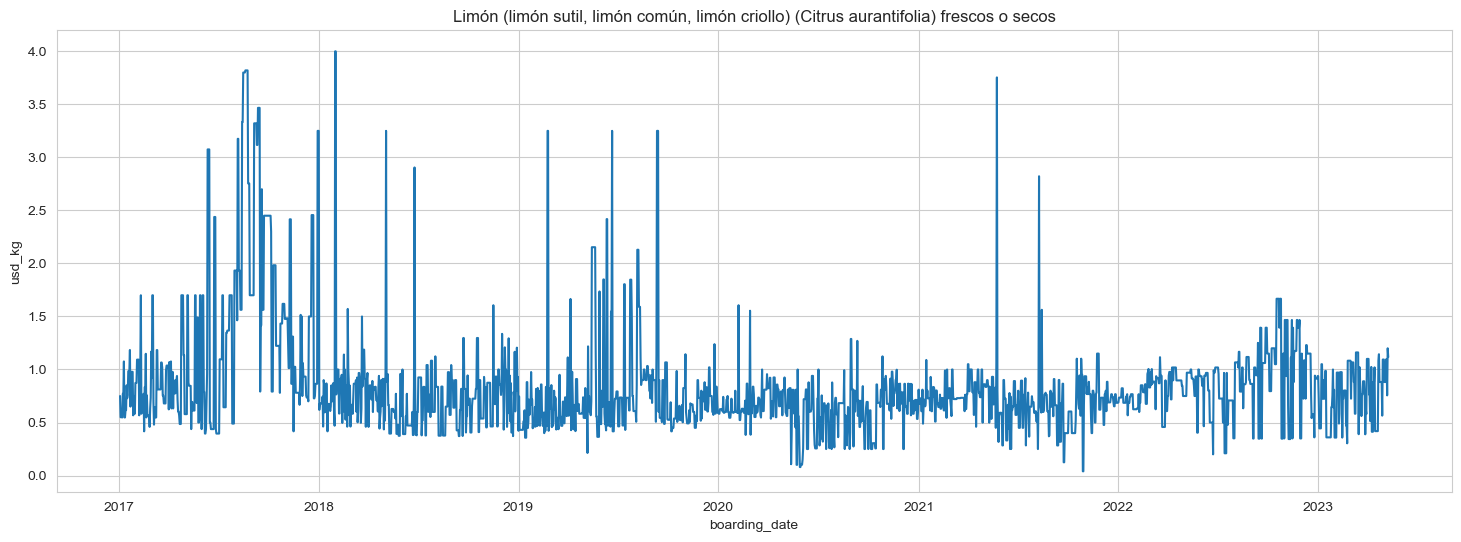

In [46]:
# Get a time-series
ts = time_series_generator.generate(chosen_heading, observations)
ts.plot()

In [47]:
# Add the time granularities
time_granularities, priority = time_granularities_generator.generate(ts.start_date, ts.end_date)
data = pd.concat([ts.data, time_granularities], axis=1)
data

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-03,0.750,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,0.550,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,0.550,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
2017-01-06,0.550,2017,1,1,1,1,1,1,6,6,6,6,5,1,1,1,1
2017-01-07,0.548,2017,1,1,1,1,1,1,7,7,7,7,6,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05,1.095,2023,1,2,5,5,2,1,125,125,35,5,5,18,18,5,1
2023-05-06,1.095,2023,1,2,5,5,2,1,126,126,36,6,6,18,18,5,1
2023-05-07,0.756,2023,1,2,5,5,2,1,127,127,37,7,7,18,18,5,1
2023-05-08,1.200,2023,1,2,5,5,2,1,128,128,38,8,1,19,19,6,2


### Get a list of the seasonal patterns to extract

In [48]:
# Get a list of seasonal patterns in order of extraction
def get_existing_granularities(granularities, data, observations):

    selected_granularities = []
    for g in granularities:
        print('Analyzing {}...'.format(g))
        seasonality_analysis = time_granularities_analysis.analysis(cyclic_granularity=g,
                                        observations=observations,
                                        data=data)
        # seasonality_analysis.plot()
        # print(seasonality_analysis.summary())
        if seasonality_analysis.is_seasonal():
            selected_granularities.append(g)
    selected_granularities = [x for x in priority if x in selected_granularities]
    selected_granularities

    return selected_granularities

### Extraction approaches

In [49]:
# Approach 1: Get the seasonal patterns, exracting each directly from the original series

def seasons_extraction(data_df, observations_column, selected_granularities):

    # Initialize the residuals
    time_series = data_df[observations_column].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data_df[granularity].values
        # Generate the pattern
        pattern = []
        for label in labels:
            value = np.mean(time_series[np.where(labels == label)])
            pattern.append(value)
        seasonal_patterns[granularity] = pattern

    return seasonal_patterns

### Extraction process

In [50]:
# Define the granularities to analyze
granularities = ['semester_in_year',
                 'quarter_in_year',
                 'month_in_year',
                 'month_in_semester',
                 'month_in_quarter',
                 'quarter_in_semester',
                 'day_in_month',
                 'day_in_week',
                 'week_in_year',
                 'week_in_semester',
                 'week_in_quarter',
                 'week_in_month']

# Get the granularities to extract
selected_granularities = get_existing_granularities(granularities, data, observations)
# Get the seasonal patterns
seasonal_patterns = seasons_extraction(data_df=data,
                                       observations_column=observations,selected_granularities=selected_granularities)


Analyzing semester_in_year...
Analyzing quarter_in_year...
Analyzing month_in_year...
Analyzing month_in_semester...
Analyzing month_in_quarter...
Analyzing quarter_in_semester...
Analyzing day_in_month...
Analyzing day_in_week...
Analyzing week_in_year...
Analyzing week_in_semester...
Analyzing week_in_quarter...
Analyzing week_in_month...


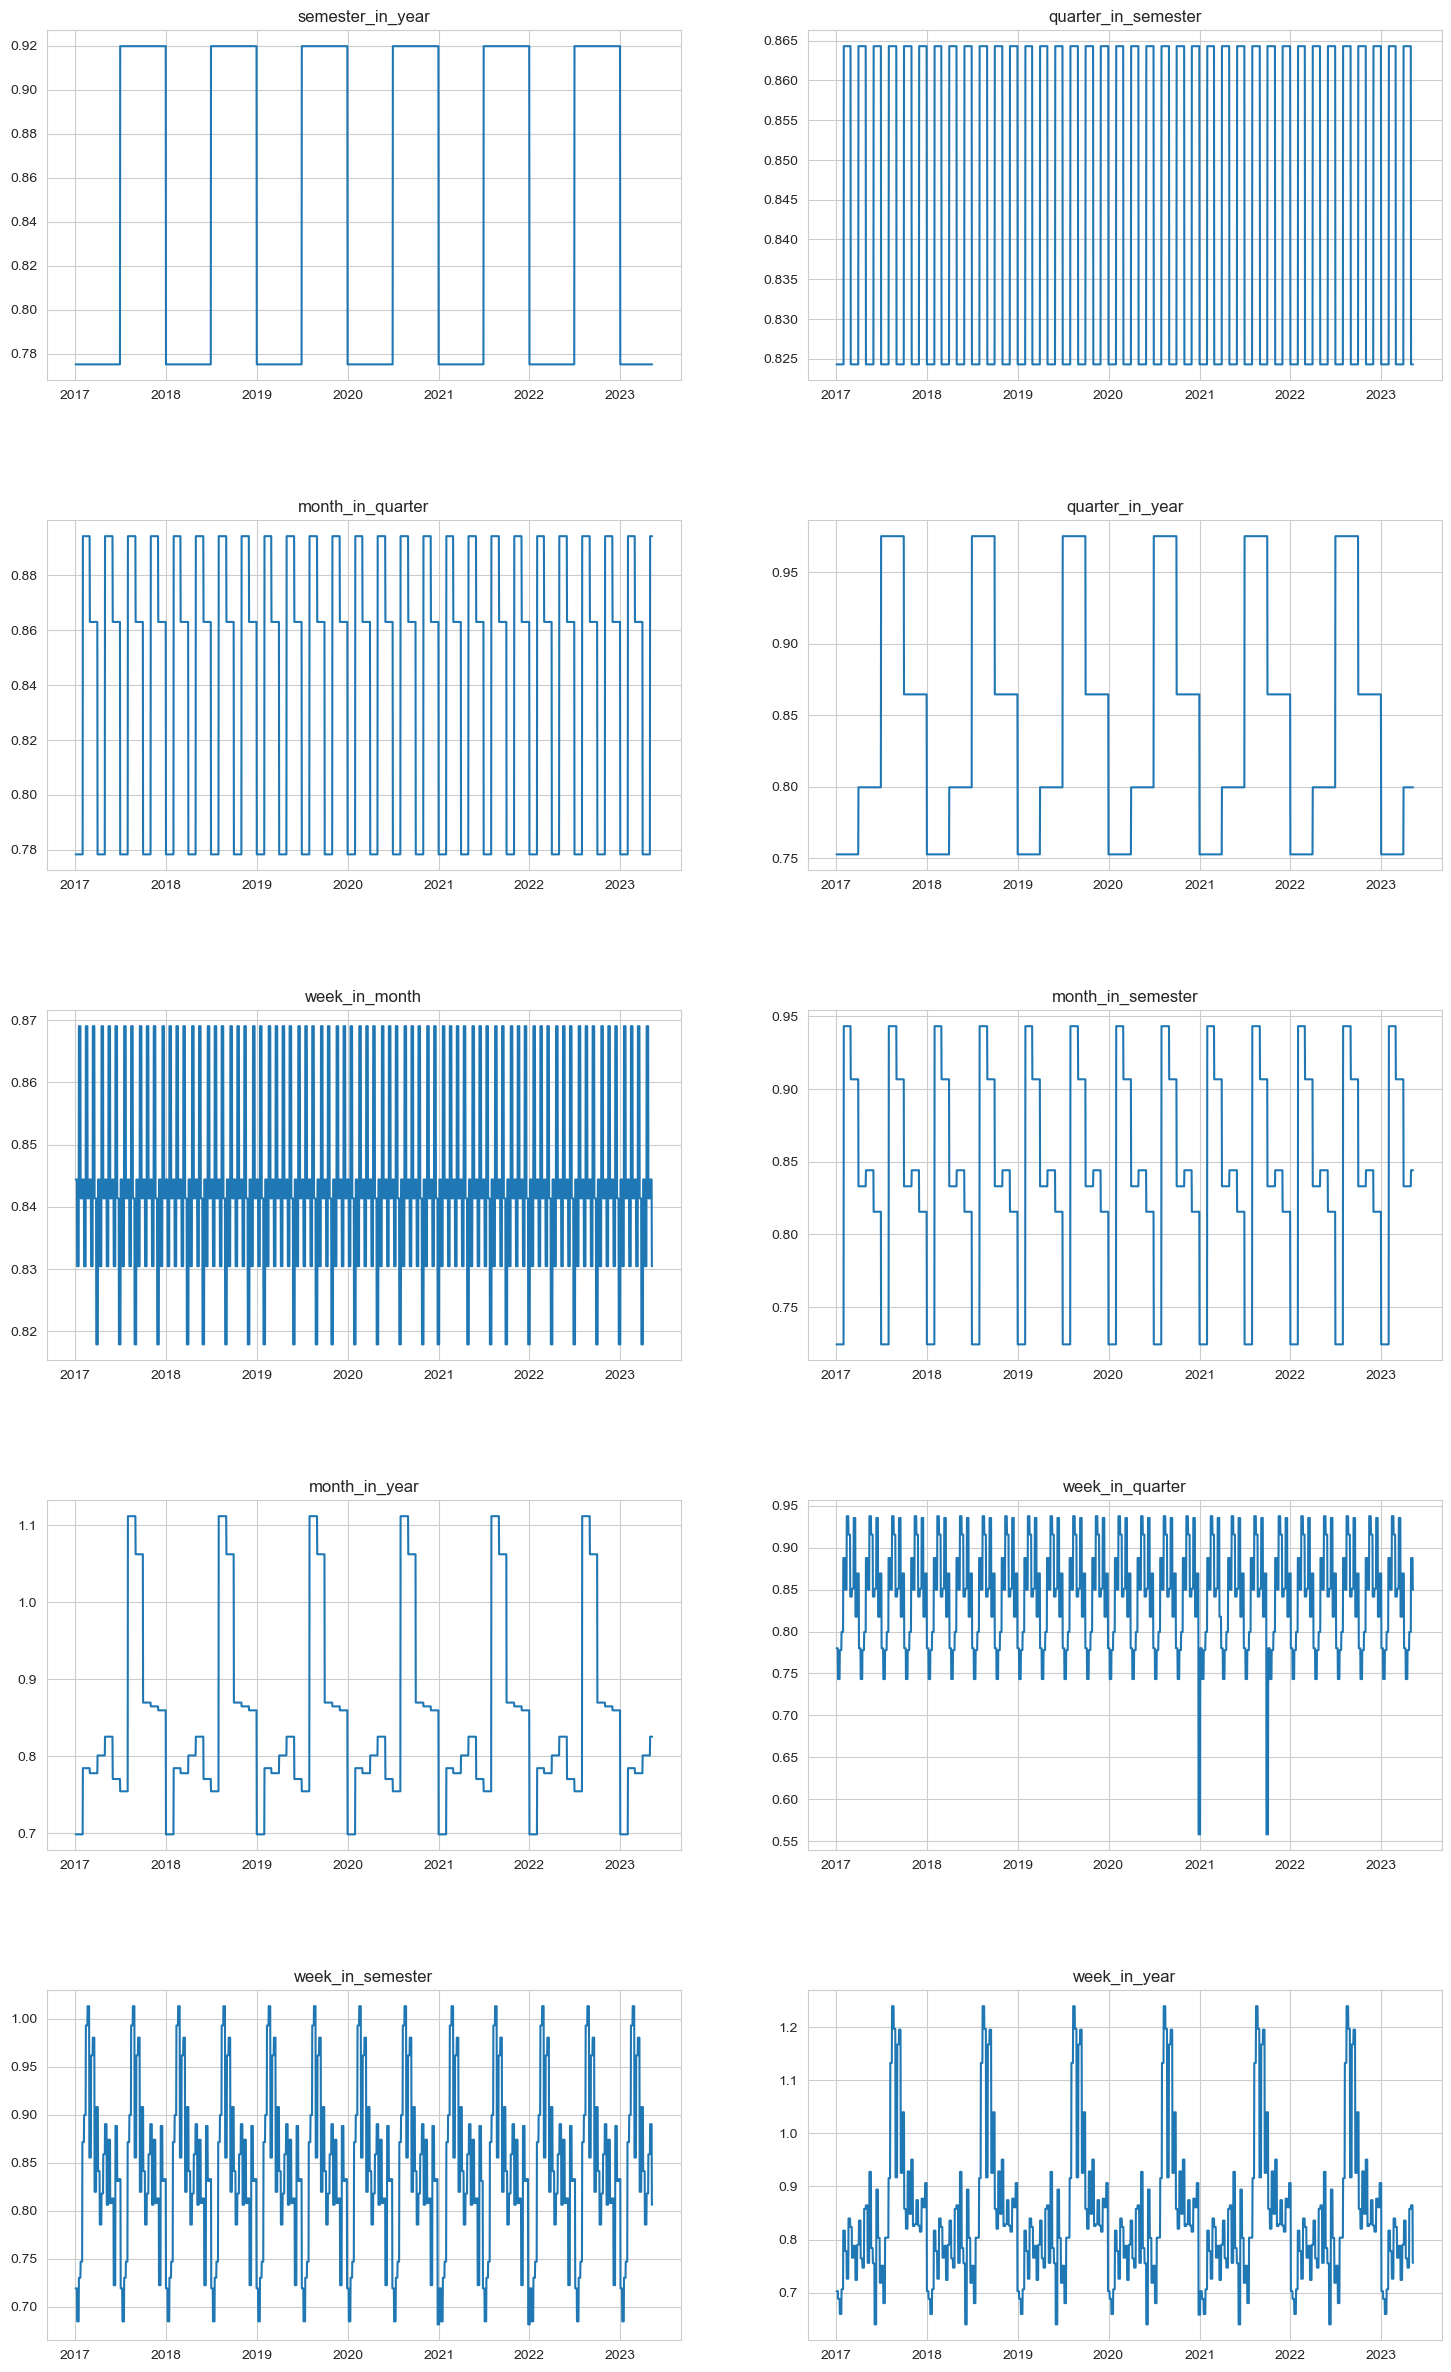

In [51]:
# Plot seasonal patterns

num_patterns = len(seasonal_patterns)
num_rows = (num_patterns + 1) // 2  # Calculate the number of rows needed for subplots

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(18, 6 * num_rows))
plt.subplots_adjust(hspace=0.4)  # Adjust the vertical spacing between subplots

# Iterate over seasonal patterns and plot them in the subplots
for i, (key, value) in enumerate(seasonal_patterns.items()):
    row = i // 2  # Row index of the subplot
    col = i % 2   # Column index of the subplot

    ax = axes[row, col]  # Get the current subplot
    sns.lineplot(x=data.index, y=value, ax=ax)
    ax.set_title(key)

# Remove empty subplots if there are more seasonal patterns than available subplots
if num_patterns % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()


### Extract the trend

In [52]:
import math
# Initialize the parameters
percentage = 0.00
# Initialize the statistics
pvalue = 1
statistic = 1
# Define the tresholds
statistic_th = 0.1
pvalue_th = 0.95

while((pvalue<pvalue_th ## while the null hypothesis (they aren't correlated) is rejected
      or
      statistic>statistic_th) ## while they are correlated
      and
      not(math.isclose(percentage, 1)) # while the fraction for the lowess isn't 100%
):
    # Increase the percentage
    percentage = round(percentage + 0.01, 2)

    # Get the trend
    trend = sm.nonparametric.lowess(data[observations], data.index, frac=percentage)[:, 1]
    # Initialize the statistics summary
    pearson_correlations ={}
    # Make the comparisons
    for granularity, seasonal_pattern in seasonal_patterns.items():

        # Compute Pearson correlation coefficient and p-value
        analysis = pearsonr(seasonal_pattern, trend)

        pearson_correlations[granularity] = {'statistic':analysis.statistic, 'pvalue':analysis.pvalue}

    # Update the condition
    statistic = max(abs(d['statistic']) for d in pearson_correlations.values())
    pvalue = max(d['pvalue'] for d in pearson_correlations.values())

pearson_correlations = pd.DataFrame.from_dict(pearson_correlations, orient='index')
print('Fraction chosen: {}'.format(percentage))

pearson_correlations

Fraction chosen: 0.16


,statistic,pvalue
semester_in_year,0.096246,0.000003
quarter_in_semester,0.006714,0.746635
month_in_quarter,0.003019,0.884507
quarter_in_year,0.075440,0.000278
week_in_month,-0.000817,0.968626
month_in_semester,-0.000542,0.979187
month_in_year,0.059799,0.003976
week_in_quarter,0.018349,0.377232
week_in_semester,0.002416,0.907459
week_in_year,0.052094,0.012126


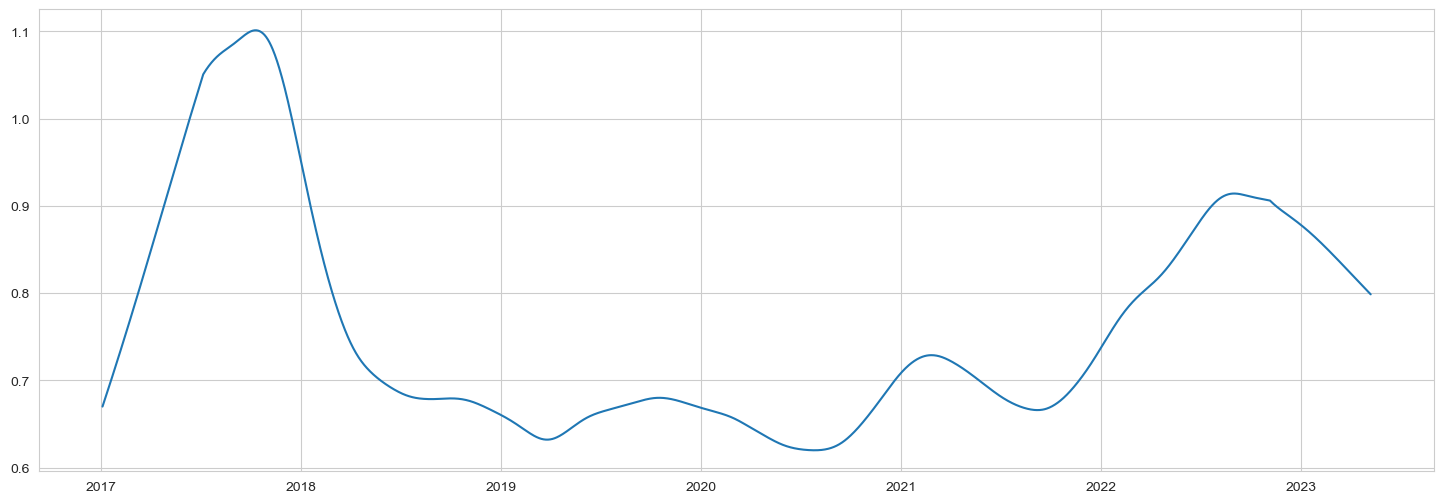

In [53]:
# Plot trend
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index, y=trend)
plt.show()

### Test a model


In [54]:
# Define the training and test set
X = np.array([trend] + list(seasonal_patterns.values())).T
y = data[observations].values

train_frac = 0.8 # fraction of the data to train with
train_size = int(train_frac * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Choose the number of steps to predict
steps = 30

### Multi-step Models

#### Multi-step Multivariate Linear Regression

Mean Rooth Squared Error: 0.37878839000741765
Mean Absolute Error: 0.2889544425552004


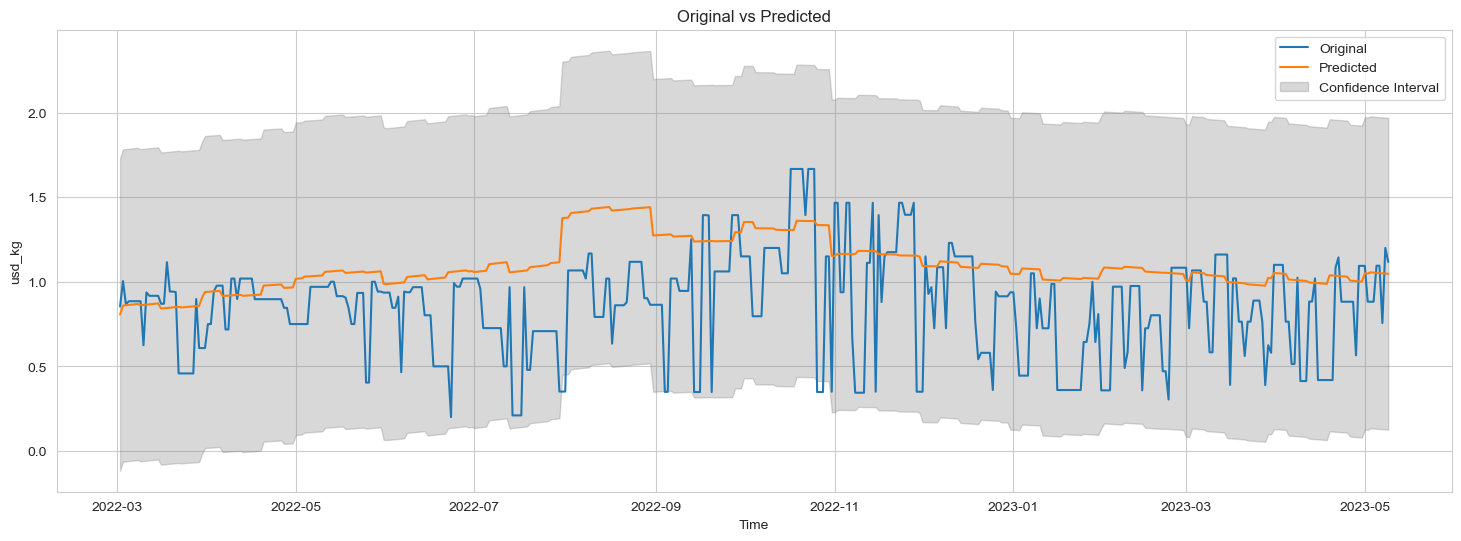

In [55]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a LinearRegression model
model = sm.OLS(y_train[steps:], X_train[:-steps])
# Fit the model to the training data
model = model.fit()

# Make predictions with the test data
y_pred = model.predict(X_test[:-steps])
conf_in = model.get_prediction((X_test[:-steps])).summary_frame(alpha=0.05)

# Calculate error metrics
mrse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
mae = mean_absolute_error(y_test[steps:], y_pred)

print("Mean Rooth Squared Error:", mrse)
print("Mean Absolute Error:", mae)

# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
plt.fill_between(data.index[-len(y_test[steps:]) :],
                 conf_in["obs_ci_lower"],
                 conf_in["obs_ci_upper"],
                 color='gray',
                 alpha=0.3,
                 label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

#----------------------------------------------------------
# Experiment tracking
#----------------------------------------------------------
wandb.init(
    mode = 'disabled',
    # set the wandb project where this run will be logged
    project="thesis_time_series_forecasting",

    # track information and parameters
    config={
    "model": 'Linear Regression',
    "observations": observations,
    "steps" : steps,
    "train_fraction": train_frac,
    "train_len" : len(X_train),
    "test_len" : len(X_test),
    }
)

# Log metrics to wandb
wandb.log({"mrse": mrse, "mae": mae, 'chart': wandb.Image(plt)})
# Finish wandb
wandb.finish()
#----------------------------------------------------------

plt.show()



#### Multi-step Generalized Additive Models (GAM)


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Root Mean Squared Error: 0.3100362884501619
Mean Absolute Error: 0.2436281831404504


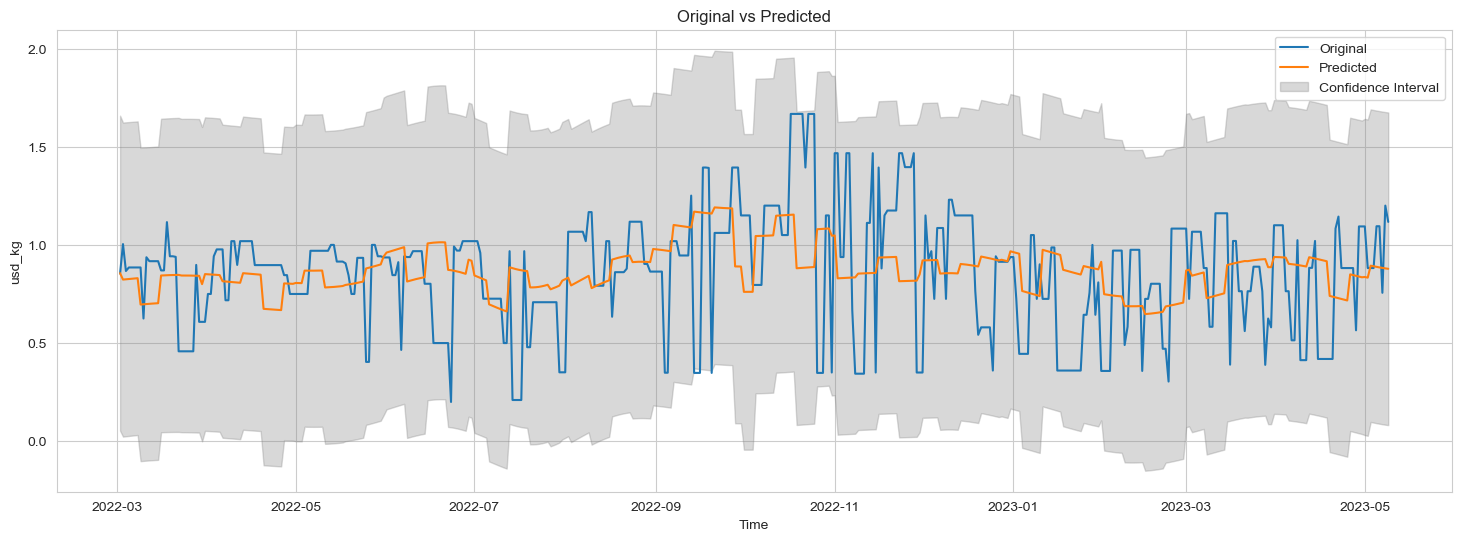

In [56]:
from pygam import LinearGAM, s, f, l, terms

# #Define the lambdas that penalize the willingness
# trend_lam = 0
# seasonal_lam = 0
# lams = [np.array([trend_lam])] + [np.copy(seasonal_lam) for _ in range(len(seasonal_patterns))]

my_terms = terms.TermList(s(0))
for i in range(len(seasonal_patterns)):
    my_terms += s(i+1, basis='cp')

# Create the GAM model
model = LinearGAM(my_terms).gridsearch(X,y)

# Make predictions with the test data
y_pred = model.predict(X_test[:-steps])
conf_in = model.prediction_intervals(X_test[:-steps], width=0.95)


# Calculate error metrics
rmse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
mae = mean_absolute_error(y_test[steps:], y_pred)

print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)


# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
plt.fill_between(data.index[-len(y_test[steps:]) :],
                 conf_in[:,0],
                 conf_in[:,1],
                 color='gray',
                 alpha=0.3,
                 label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

#----------------------------------------------------------
# Experiment tracking
#----------------------------------------------------------
wandb.init(
    mode = 'disabled',
    # set the wandb project where this run will be logged
    project="thesis_time_series_forecasting",

    # track information and parameters
    config={
    "model": 'GAM',
    "observations": observations,
    "steps" : steps,
    "train_fraction": train_frac,
    "train_len" : len(X_train),
    "test_len" : len(X_test),
    "terms" : str(my_terms)
    }
)

# Log metrics to wandb
plt.savefig('chart.png', format='png')
wandb.log({"mrse": mrse, "mae": mae, 'chart': wandb.Image(plt)})
# Finish wandb
wandb.finish()
#----------------------------------------------------------

plt.show()


In [57]:
# for i, term in enumerate(model.terms):
#     if term.isintercept:
#         continue
#
#     XX = model.generate_X_grid(term=i)
#     pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
#
#     plt.figure()
#     plt.plot(XX[:, term.feature], pdep)
#     plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#     plt.title(repr(term))
#     plt.show()

In [58]:
# # See the original and transformed predictors
#
# # Trend
# transformed_trend = model.partial_dependence(term=0, X=X)
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=trend, label='Original')
# sns.lineplot(x=data.index, y=transformed_trend, label='Transformed')
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Transformed Trend')
# plt.legend()
# plt.show()
#
# # Seasonal components
#
# for index, (granularity, pattern) in enumerate(seasonal_patterns.items()):
#
#     transformed_pattern = model.partial_dependence(term=index+1, X=X)
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=pattern, label='Original')
#     sns.lineplot(x=data.index, y=transformed_pattern, label='Transformed')
#     plt.xlabel('Time')
#     plt.ylabel(observations)
#     plt.title('Original vs Transformed {}'.format(granularity))
#     plt.legend()
#     plt.show()


#### Multi-step Multivariate Prophet using seasonal patterns and trend

20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:40 - cmdstanpy - INFO - Chain [1] done processing


Mean Rooth Squared Error: 0.3347426642649291
Mean Absolute Error: 0.2539656607099524


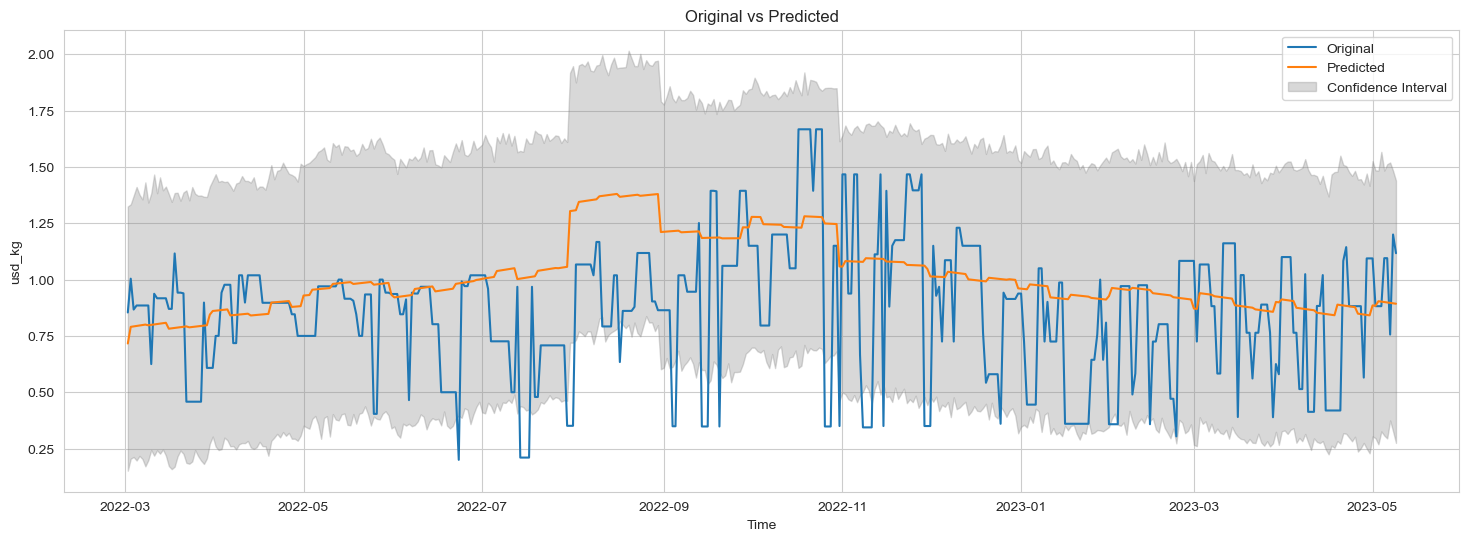

In [59]:
#### Prophet
from prophet import Prophet

# Format the data
# Training data
prophet_train = pd.DataFrame({'ds': data.index[steps:train_size],
                              'y' : data[observations].values[steps:train_size]})
for i in range(X_train[:-steps].shape[1]) :
    if i==0:
        prophet_train['my_trend']=X_train[:-steps,i]
    else:
        for c, granularity in enumerate(seasonal_patterns.keys()):
            if c==(i-1):
                prophet_train[granularity]=X_train[:-steps,i]

# Test data
prophet_test = pd.DataFrame({'ds': data.index[train_size+steps:],
                              'y' : data[observations].values[train_size+steps:]})
for i in range(X_test[:-steps].shape[1]) :
    if i==0:
        prophet_test['my_trend']=X_test[:-steps,i]
    else:
        for c, granularity in enumerate(seasonal_patterns.keys()):
            if c==(i-1):
                prophet_test[granularity]=X_test[:-steps,i]

# Create the model
# Remove the default seasonalities
m = Prophet(weekly_seasonality=False, yearly_seasonality=False)
# Add the trend patterns
m.add_regressor('my_trend', standardize=False)
# Add the seasonal patterns
for granularity in seasonal_patterns.keys():
    m.add_regressor(granularity, standardize=False)

# Fit the model
m.fit(prophet_train)

# Make the future dataframe with the test dates
future = prophet_test

# Make predictions
forecast = m.predict(future)

# Calculate error metrics
mrse = np.sqrt(mean_squared_error(prophet_test['y'], forecast['yhat']))
mae = mean_absolute_error(prophet_test['y'], forecast['yhat'])
print("Mean Rooth Squared Error:", mrse)
print("Mean Absolute Error:", mae)

# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index[-len(prophet_test):], y=prophet_test['y'], label='Original')
sns.lineplot(x=data.index[-len(prophet_test):], y=forecast['yhat'], label='Predicted')
plt.fill_between(data.index[-len(prophet_test):],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='gray',
                 alpha=0.3,
                 label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

plt.show()

#### Univariate Prophet


20:30:41 - cmdstanpy - INFO - Chain [1] start processing
20:30:41 - cmdstanpy - INFO - Chain [1] done processing


Mean Rooth Squared Error: 0.36072600082987644
Mean Absolute Error: 0.2995425593618612


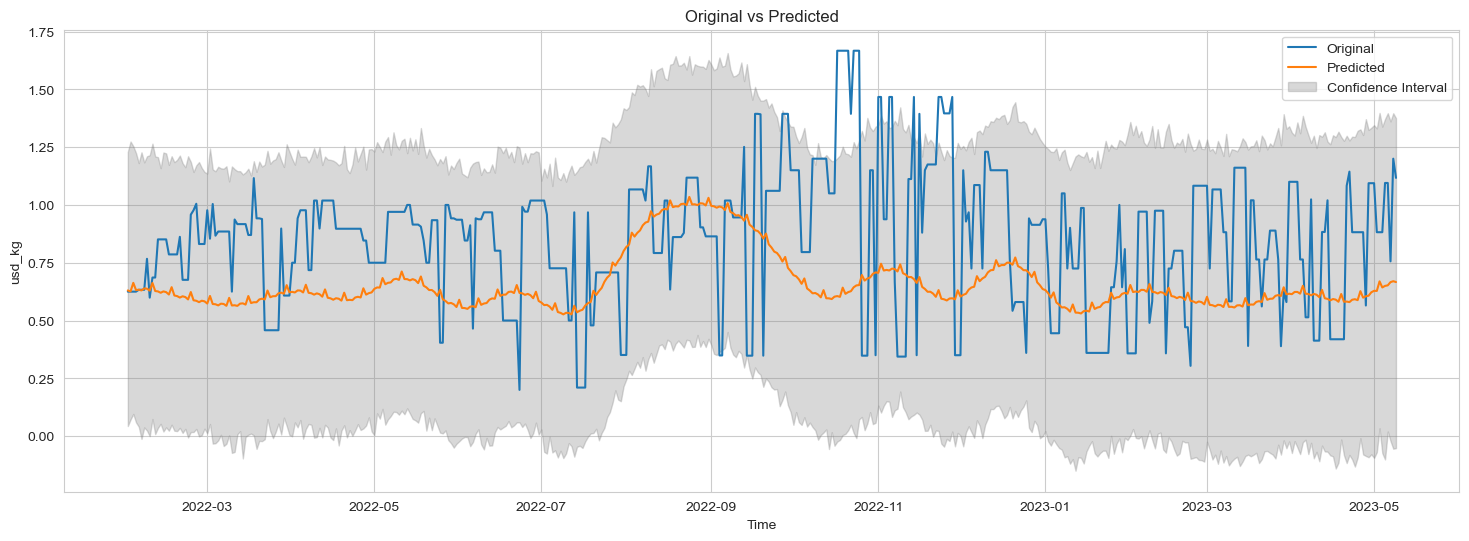

In [60]:
#### Prophet
from prophet import Prophet

# Format the data
prophet_data = data[[observations]].copy()
prophet_data.index.name = 'ds'
prophet_data.reset_index(inplace=True)
prophet_data.rename(columns={observations: 'y'}, inplace=True)

# Training data
prophet_train = prophet_data[:train_size]
# Test data
prophet_test = prophet_data[train_size:]

# Create the model
m = Prophet()
# Fit the model
m.fit(prophet_train)

# Make the future dataframe with the test dates
future = prophet_test[['ds']]

# Make predictions
forecast = m.predict(future)

# Calculate error metrics
mrse = np.sqrt(mean_squared_error(prophet_test['y'], forecast['yhat']))
mae = mean_absolute_error(prophet_test['y'], forecast['yhat'])
print("Mean Rooth Squared Error:", mrse)
print("Mean Absolute Error:", mae)

# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index[-len(prophet_test):], y=prophet_test['y'], label='Original')
sns.lineplot(x=data.index[-len(prophet_test):], y=forecast['yhat'], label='Predicted')
plt.fill_between(data.index[-len(prophet_test):],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='gray',
                 alpha=0.3,
                 label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

#----------------------------------------------------------
# Experiment tracking
#----------------------------------------------------------
wandb.init(
    mode='disabled',
    # set the wandb project where this run will be logged
    project="thesis_time_series_forecasting",

    # track information and parameters
    config={
        "model": 'Prophet',
        "observations": observations,
        "train_fraction": train_frac,
        "train_len": len(prophet_train),
        "test_len": len(prophet_test),
        "periods": False
    }
)

# Log metrics to wandb
wandb.log({"mrse": mrse, "mae": mae, 'chart': wandb.Image(plt)})
# Finish wandb
wandb.finish()
#----------------------------------------------------------

plt.show()

#### Prophet (with extracted patterns)


20:30:42 - cmdstanpy - INFO - Chain [1] start processing
20:30:42 - cmdstanpy - INFO - Chain [1] done processing


Mean Rooth Squared Error: 0.3367473224864398
Mean Absolute Error: 0.2785936624707914


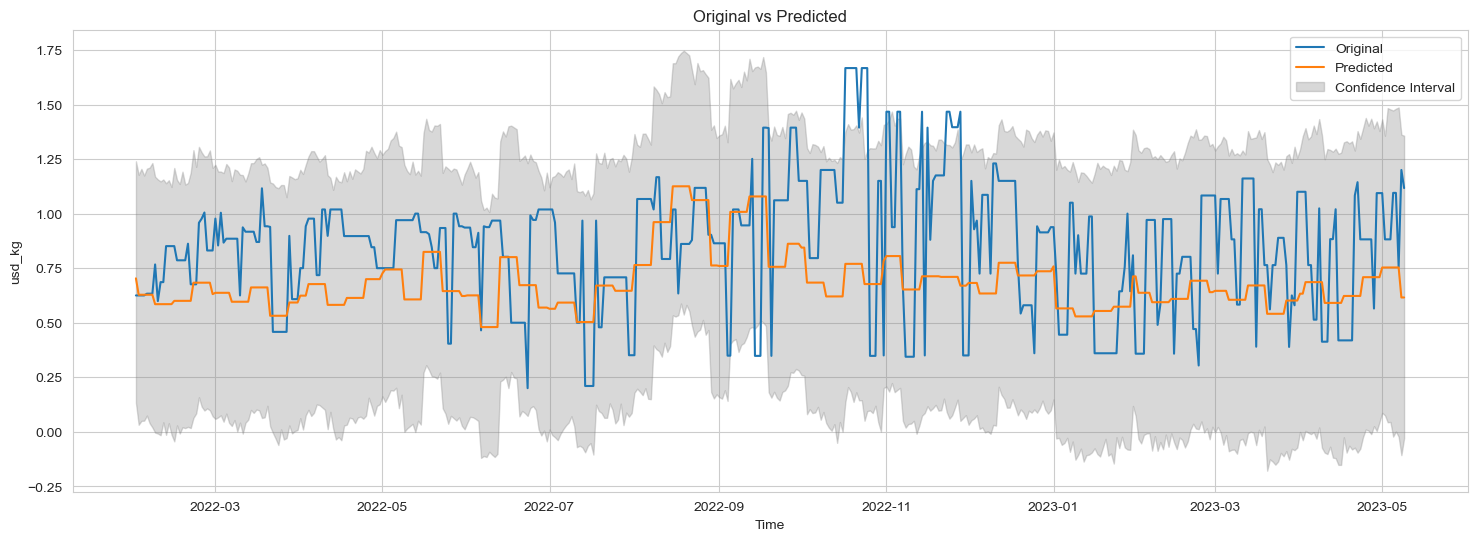

In [61]:
from prophet import Prophet

# Format the data
prophet_data = pd.DataFrame({'ds': data.index, 'y': data[observations].values})
for granularity, pattern in seasonal_patterns.items():
    prophet_data[granularity] = pattern
prophet_data

# Training data
prophet_train = prophet_data[:train_size]
# Test data
prophet_test = prophet_data[train_size:]
prophet_data

# Create the model
# Remove the default seasonalities
m = Prophet(weekly_seasonality=False, yearly_seasonality=False)
# Add the seasonal patterns
for granularity in seasonal_patterns.keys():
    m.add_regressor(granularity, standardize=False)

# Fit the model
m.fit(prophet_train)

# Make the future dataframe with the test dates
future = prophet_data[train_size:].loc[:, prophet_data.columns != 'y']

# Make predictions
forecast = m.predict(future)

# Calculate error metrics
mrse = np.sqrt(mean_squared_error(prophet_test['y'], forecast['yhat']))
mae = mean_absolute_error(prophet_test['y'], forecast['yhat'])
print("Mean Rooth Squared Error:", mrse)
print("Mean Absolute Error:", mae)
# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index[-len(prophet_test):], y=prophet_test['y'], label='Original')
sns.lineplot(x = data.index[-len(prophet_test):], y=forecast['yhat'], label='Predicted')
plt.fill_between(data.index[-len(prophet_test):],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='gray',
                 alpha=0.3,
                 label='Confidence Interval')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

#----------------------------------------------------------
# Experiment tracking
#----------------------------------------------------------
wandb.init(
    mode = 'disabled',
    # set the wandb project where this run will be logged
    project="thesis_time_series_forecasting",

    # track information and parameters
    config={
    "model": 'Prophet',
    "observations": observations,
    "train_fraction": train_frac,
    "train_len" : len(prophet_train),
    "test_len" : len(prophet_test),
    "periods": True
    }
)

# Log metrics to wandb
wandb.log({"mrse": mrse, "mae": mae, 'chart': wandb.Image(plt)})
# Finish wandb
wandb.finish()
#----------------------------------------------------------

plt.show()


#### ARIMA

In [62]:
# from statsmodels.tsa.arima.model import ARIMA
#
# # Get the train and test data
# train, test = data[observations].values[:train_size], data[observations].values[train_size:]
#
# # Create model
# # fit model
# model = ARIMA(train, order=(1,1,1), seasonal_order=(7,1,7,30))
# # Fit model
# model = model.fit()
#
# # Make predictions
# forecast = model.predict(start=train_size+1, end=train_size+len(test))
#
# # Calculate error metrics
# mrse = np.sqrt(mean_squared_error(test, forecast))
# mae = mean_absolute_error(test, forecast)
# print("Mean Rooth Squared Error:", mrse)
# print("Mean Absolute Error:", mae)
#
#
# # Plot original vs predicted
# plt.figure(figsize=(18, 6))
# sns.lineplot(x = data.index[-len(test):], y=test, label='Original')
# sns.lineplot(x = data.index[-len(test):], y=forecast, label='Predicted')
#
# plt.xlabel('Time')
# plt.ylabel(observations)
# plt.title('Original vs Predicted')
# plt.legend()
#
# plt.show()


#### Multi-step Gradient Boosting


Mean Rooth Squared Error: 0.2981000998922308
Mean Absolute Error: 0.23713940733154296


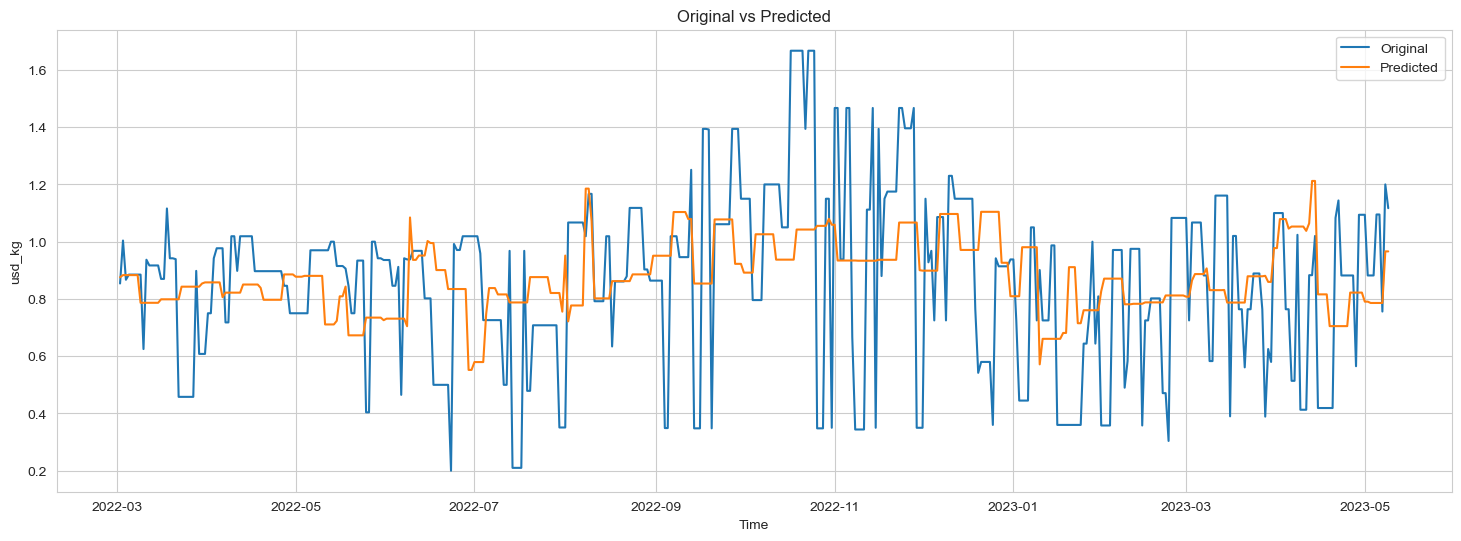

In [63]:
from sklearn import ensemble


params = {
    "n_estimators": 2000,
    "max_depth": 4,
    "min_samples_split": 10,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# Create a model
model = ensemble.GradientBoostingRegressor(**params)
# Fit the model to the training data
model.fit(X_train[:-steps], y_train[steps:])

# Make predictions with the test data
y_pred = model.predict(X_test[:-steps])

# Calculate error metrics
mrse = np.sqrt(mean_squared_error(y_test[steps:], y_pred))
mae = mean_absolute_error(y_test[steps:], y_pred)

print("Mean Rooth Squared Error:", mrse)
print("Mean Absolute Error:", mae)


# Plot original vs predicted
plt.figure(figsize=(18, 6))
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_test[steps:], label='Original')
sns.lineplot(x = data.index[-len(y_test[steps:]):], y=y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel(observations)
plt.title('Original vs Predicted')
plt.legend()

plt.show()
